In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults
from datetime import datetime
import pandas_datareader as pdr

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')
max_temp.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66062,1859,1,1,24.4,NaN,Y
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y
3,IDCJAC0010,66062,1859,1,4,24.7,1.0,Y
4,IDCJAC0010,66062,1859,1,5,24.6,1.0,Y


In [3]:
max_temp.to_csv('C:\\Users\\nafissaad\\Tutorial\\Time series\\Quaintpy Weather Derivatives\\2 Statistical Analysis of Temperature Data\\max_temp1.csv')
min_temp.to_csv('C:\\Users\\nafissaad\\Tutorial\\Time series\\Quaintpy Weather Derivatives\\2 Statistical Analysis of Temperature Data\\min_temp2.csv')

In [4]:
max_temp.isnull().value_counts(),min_temp.isna().value_counts()

count = 0
for mx, mn in zip(np.where(max_temp.isnull())[0], np.where(min_temp.isnull())[0]):
    if mx != mn:
        count += 1
        
print('Number of Misaligned Null Values: ', count)

Number of Misaligned Null Values:  41


In [5]:
def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)


In [6]:
max_temp['Date'] = max_temp.apply(datetime,axis=1)#axis=1 operates as per column wise 
min_temp['Date'] = min_temp.apply(datetime,axis=1)


In [7]:
max_temp

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality,Date
0,IDCJAC0010,66062,1859,1,1,24.4,NaN,Y,1859-01-01
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y,1859-01-02
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y,1859-01-03
3,IDCJAC0010,66062,1859,1,4,24.7,1.0,Y,1859-01-04
4,IDCJAC0010,66062,1859,1,5,24.6,1.0,Y,1859-01-05
...,...,...,...,...,...,...,...,...,...
59713,IDCJAC0010,66214,2022,6,29,17.9,1.0,N,2022-06-29
59714,IDCJAC0010,66214,2022,6,30,16.9,1.0,N,2022-06-30
59715,IDCJAC0010,66214,2022,7,1,12.0,1.0,N,2022-07-01
59716,IDCJAC0010,66214,2022,7,2,15.8,1.0,N,2022-07-02


In [8]:
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)

In [9]:
#Dropping columns
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
#Rename columns
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)
#Merging Columns
temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])
#Making Average
def avg_temp(row):
    return (row.Tmax+row.Tmin)/2
temps['T'] = temps.apply(avg_temp,axis=1)
temps=temps.dropna()
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2022-06-29,17.9,8.0,12.95
2022-06-30,16.9,10.2,13.55
2022-07-01,12.0,10.3,11.15


In [10]:
temps.isnull().sum()

Tmax    0
Tmin    0
T       0
dtype: int64

In [11]:
temp_season=temps.copy(deep=True)
temp_season['month']=temp_season.index.month
mask=(temp_season['month']>=5)&(temp_season['month']<=10)
temp_season['winter']=np.where(mask,1,0)
temp_season['summer']=np.where(temp_season['winter']!=1,1,0)
temp_season[0:300]

,Tmax,Tmin,T,month,winter,summer
Date,,,,,,
1859-01-01,24.4,14.5,19.45,1,0,1
1859-01-02,24.4,15.7,20.05,1,0,1
1859-01-03,24.2,15.3,19.75,1,0,1
1859-01-04,24.7,17.4,21.05,1,0,1
1859-01-05,24.6,16.9,20.75,1,0,1
...,...,...,...,...,...,...
1859-10-23,20.9,14.5,17.70,10,1,0
1859-10-24,22.8,9.5,16.15,10,1,0
1859-10-25,17.6,10.7,14.15,10,1,0


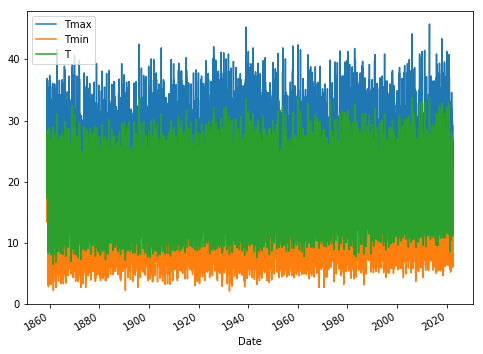

In [12]:
temps[:].plot(figsize=(8,6))
plt.show()

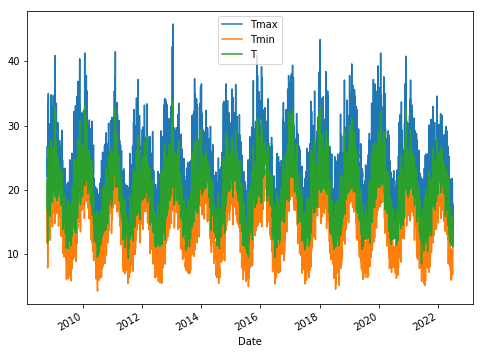

In [13]:
temps[-5000:].plot(figsize=(8,6))
plt.show()

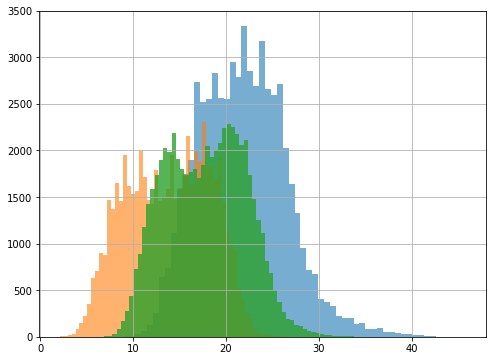

In [14]:
# Data distribution
plt.figure(figsize=(8,6))
temps.Tmax.hist(bins=60, alpha=0.6, label='Tmax')
temps.Tmin.hist(bins=60, alpha=0.6, label='Tmin')
temps['T'].hist(bins=60, alpha=0.8, label='T')
plt.legend
plt.show()

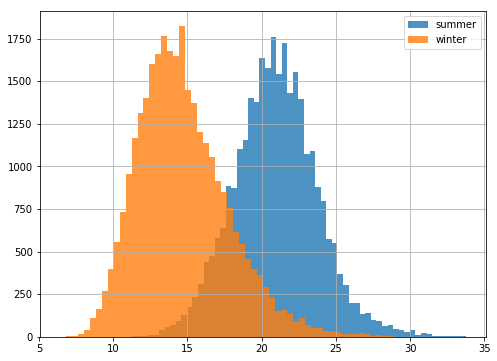

In [15]:
plt.figure(figsize=(8,6))
temp_season[temp_season['summer'] == 1]['T'].hist(bins=60, alpha=0.8, label='summer')
temp_season[temp_season['winter'] == 1]['T'].hist(bins=60, alpha=0.8, label='winter')
plt.legend()
plt.show()

In [16]:
date_list=temps.index.tolist()
mth_temps=pd.DataFrame(data=date_list,index=date_list).resample('MS')[0].agg([min,max])
mth_temps['month'] = mth_temps.index.month
mth_temps

,min,max,month
1859-01-01,1859-01-01,1859-01-31,1
1859-02-01,1859-02-01,1859-02-28,2
1859-03-01,1859-03-01,1859-03-31,3
1859-04-01,1859-04-01,1859-04-30,4
1859-05-01,1859-05-01,1859-05-31,5
...,...,...,...
2022-03-01,2022-03-01,2022-03-31,3
2022-04-01,2022-04-01,2022-04-30,4
2022-05-01,2022-05-01,2022-05-31,5
2022-06-01,2022-06-01,2022-06-30,6


In [17]:
def min_max_temps(row):
    stats = temps[(temps.index >= row['min']) & (temps.index <= row['max'])].agg([min, max])#between 1 month date condition i will find temps man min for each column 
    #print(stats)
    row['Tmax_max'] = stats.loc['max', 'Tmax']
    row['Tmax_min'] = stats.loc['min', 'Tmax']
    row['Tmin_max'] = stats.loc['max', 'Tmin']
    row['Tmin_min'] = stats.loc['min', 'Tmin']
    row['T_max'] = stats.loc['max', 'T']
    row['T_min'] = stats.loc['min', 'T']
    return row
    
mth_temps = mth_temps.apply(min_max_temps,axis=1)
mth_temps

,min,max,month,Tmax_max,Tmax_min,Tmin_max,Tmin_min,T_max,T_min
1859-01-01,1859-01-01,1859-01-31,1,36.9,20.6,19.9,14.5,28.40,18.10
1859-02-01,1859-02-01,1859-02-28,2,35.6,19.9,20.0,13.3,26.95,17.25
1859-03-01,1859-03-01,1859-03-31,3,30.4,18.8,18.9,13.3,23.55,17.10
1859-04-01,1859-04-01,1859-04-30,4,31.1,16.8,17.7,7.8,22.45,13.25
1859-05-01,1859-05-01,1859-05-31,5,28.6,13.9,16.7,4.6,22.65,9.25
...,...,...,...,...,...,...,...,...,...
2022-03-01,2022-03-01,2022-03-31,3,28.6,21.5,21.4,15.1,24.45,19.50
2022-04-01,2022-04-01,2022-04-30,4,29.9,18.2,17.9,13.1,23.30,15.90
2022-05-01,2022-05-01,2022-05-31,5,26.8,14.9,18.2,8.2,21.45,12.05
2022-06-01,2022-06-01,2022-06-30,6,21.8,15.0,10.9,6.0,16.05,11.30


In [18]:
grouped_mths = mth_temps.groupby(mth_temps.month)[['Tmax_max', 'Tmax_min', 'Tmin_max', 'Tmin_min','T_max','T_min']].agg([min, max])
grouped_mths['months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouped_mths = grouped_mths.set_index('months')
grouped_mths[[('T_max', 'max'),('T_max', 'min'),('T_min', 'max'),('T_min', 'min')]]
#grouped_mths

T_max         T_min       
          max    min    max    min
months                            
Jan     33.75  22.75  21.95  15.05
Feb     33.10  23.20  21.95  12.60
Mar     31.75  22.15  20.65  13.10
Apr     29.10  19.45  18.20  11.20
May     24.55  16.20  14.95   9.20
Jun     21.60  13.25  12.90   7.80
Jul     20.90  12.35  12.50   6.40
Aug     25.05  14.45  12.45   7.30
Sep     26.90  17.25  15.25   7.85
Oct     30.55  19.05  17.50   9.90
Nov     32.90  20.40  18.35  12.45
Dec     32.60  22.05  20.40  14.00

In [19]:
#seasonal_decompose
temps.sort_index(inplace=True)
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2022-06-29,17.9,8.0,12.95
2022-06-30,16.9,10.2,13.55
2022-07-01,12.0,10.3,11.15


In [20]:
temps.sort_index(inplace=True)
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2022-06-29,17.9,8.0,12.95
2022-06-30,16.9,10.2,13.55
2022-07-01,12.0,10.3,11.15


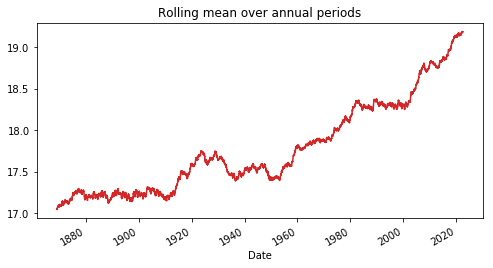

In [21]:
temps['T'].rolling(window=365*10).mean().plot(figsize=(8,4),color='tab:red',title='Rolling mean over annual periods')

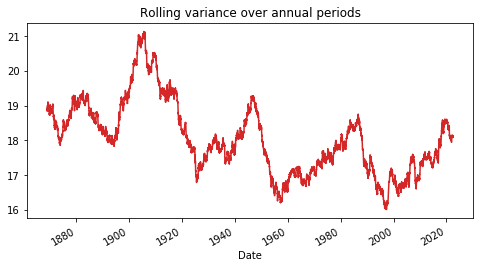

In [22]:
temps['T'].rolling(window = 365*10).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over annual periods");

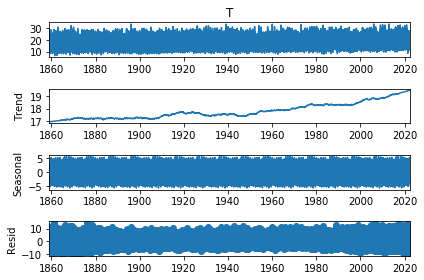

(-15, 15)

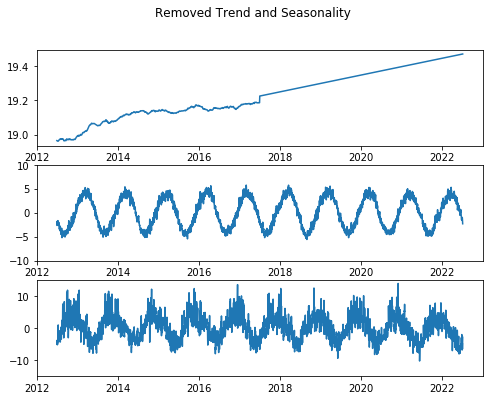

In [23]:
decompose_result = seasonal_decompose(temps['T'], model='additive', period=int(365*10), extrapolate_trend='freq')

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

### Visualise All Data
decompose_result.plot()
plt.show()

### Visualise 10 years
years_examine = 365*10
fig, axs = plt.subplots(3, figsize=(8,6))
fig.suptitle('Removed Trend and Seasonality')
axs[0].plot(trend[-years_examine:])
axs[1].plot(seasonal[-years_examine:])#because we are visualising last 10 years data
axs[1].set_ylim([-10,10])
axs[2].plot(residual[-years_examine:])
axs[2].set_ylim([-15,15])

In [24]:
#Noise is still not stationary it means it still has some seasonality in it
def adfuller_test(sales):
    result= adfuller(sales)
    labels = ["ADF Test Statistics","p-value","#Lags Used","Number of Observations Used"]
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(residual)

In [ ]:
dftest = adfuller(residual, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

In [ ]:
#Statistically we faound the data set stationary but visually we can see there is a seasonalisty

In [ ]:
residual.hist(bins=60, figsize=(8,6))#Residuals  are normally distributed but we know there is a correlation

In [ ]:
plot_acf(residual, lags=100)#till 90 days it has auto correlation so, it has seasonality
plt.show()

In [ ]:
plot_pacf(residual, lags=40,method='ywm')
plt.show()

In [ ]:
#Find the best lag that doesn't over fit the model
residuals = residual.copy(deep=True)
residuals 

In [ ]:
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')
residuals

In [ ]:
mod = ar_select_order(residuals, maxlag=40, ic='aic')#, old_names=True)

aic = []
for key, val in mod.aic.items():
    #print(key)
    if key != 0:
        aic.append((key[-1], val))
#print(aic)
aic.sort()    
x,y = [x for x,y in aic],[y for x,y in aic]
#print(x,y)
plt.scatter(x, y)
#plt.plot([0,40],[y[15],y[15]], 'tab:orange')
#plt.text(3,y[15]+0.002, '{0}'.format(round(y[15],3)),color='tab:orange')
#plt.plot([0,40],[y[20],y[20]], 'k--')
#plt.text(3,y[20]-0.004, '{0}'.format(round(y[20],3)))
plt.title("AIC Criterion")
plt.xlabel("Lags in AR Model")
plt.ylabel("AIC")
plt.show()

In [ ]:
0!=1

In [ ]:
model = AutoReg(residuals, lags=15)#, old_names=True)#,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
res.index = res.index.to_timestamp()
res,coef

In [ ]:
model = AutoReg(residuals, lags=15,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
res.index = res.index.to_timestamp()
print(model_fit.summary())

fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Residuals after AR(15) model')
axs[0,0].plot(res)
axs[1,0].plot(res[-200:])
plot_acf(res, lags=20, ax=axs[0,1])
plot_pacf(res, lags=20, ax=axs[1,1],method='ywm')
plt.show()


In [ ]:
from scipy.stats import norm
qqplot(res, marker='x', dist=norm, loc=0, scale=np.std(res), line='45')
plt.show()

In [ ]:
#res is my  actual Residual,it has no autocorrelation